## Interest Rate Prediction Using Lasso Regression on Leanding Club Data with Python
Author: Simbarashe Timire <>
Date : 22 October 2021

### 1. Introduction
The goal of this project is to predict interest rates for new loans using lasso regression. I use [Lending Club](https://www.lendingclub.com/) historical lending data which they have made publicly available. 

In [1]:
#Importing Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import janitor
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale

### 1.1. ICEing the Data
(

**Inspect** - we are going to understand each variable definition, units of measurments and if there is any issues eg missing data or incorrect entries,

**Clean** - we are then going to clean the data, decide what to do with missing values and also transform data into usable forms such as coding some variables into factors/categorical ,

**Explore** - data exploration is important for coming up with initial hypotheses with the help of domain experts. We explore through visualising data eg with correllation charts and histograms etc.

)

Most project failures are due to improper ICEing

In [2]:
import warnings
warnings.filterwarnings('ignore') 
lending_df = pd.read_csv("LendingClub_Data.csv").clean_names().remove_empty() #use pandas to load the data

The section below I clean the data and make sure it is in the right format for visualisation and exploration

In [3]:
new_header = lending_df.iloc[0] #grab the first row for the header
lending_df = lending_df[1:] #take the data less the header row
lending_df.columns = new_header #set the header row as the df header
#selecting columns and renaming term feature
lending_df = lending_df.iloc[:, 0:19].dropna().rename(columns={"term (months)": "term_months"})
lending_df.head(3) #visualising the df

,int_rate,loan_amnt,term_months,installment,dti,delinq_2yrs,annual_inc,grade,emp_title,emp_length,home_ownership,verification_status,issue_d,zip_code,addr_state,loan_status,desc,purpose,title
2,0.05,6000,36,180.96,5.73,0,52800,A,coral graphics,< 1 year,MORTGAGE,Source Verified,9/1/2011,228xx,VA,Charged Off,Borrower added on 09/08/11 > excellent credi...,vacation,bad choice
6,0.05,6000,36,180.96,21.92,0,89000,A,FBI,2 years,MORTGAGE,Not Verified,9/1/2011,760xx,TX,Fully Paid,Borrower added on 09/08/11 > This loan is to...,home_improvement,Siding - Allied
8,0.05,15000,36,452.4,9.72,0,135000,A,A Technical Consulting Firm,2 years,MORTGAGE,Source Verified,9/1/2011,980xx,WA,Fully Paid,"Borrower added on 09/07/11 > Hey all, thanks...",debt_consolidation,Payoff the bloody credit card!


In [4]:
#changing the term_months  and delinq_2yrs to same type
lending_df['term_months'] = lending_df['term_months'].astype('string')
lending_df['delinq_2yrs'] = lending_df['delinq_2yrs'].astype('string')
#making sure we dont have duplicate levels in term_months
lending_df["term_months"].replace({"36.0": "36", "60.0": "60"}, inplace=True)
#checking if we have the right number of terms/ levels
lending_df['term_months'].unique()

array(['36', '60'], dtype=object)

In [5]:
cols = ['term_months', 'delinq_2yrs', 'grade'] 
lending_df[cols] = lending_df[cols].astype('category') #changing term_months and delinq variables to categorical

In [6]:
mycols = ["emp_title", "installment", "term_months"]
#rearranging columns and putting less important column to the last 
lending_clean = lending_df.reindex(lending_df.columns[~lending_df.columns.isin(mycols)].tolist() + mycols,
                 axis='columns') 

In [7]:
#visualising the structure of the dataset
lending_clean.describe()

,int_rate,loan_amnt,dti,delinq_2yrs,annual_inc,grade,emp_length,home_ownership,verification_status,issue_d,zip_code,addr_state,loan_status,desc,purpose,title,emp_title,installment,term_months
count,23935.00,23935,23935.0,23935,23935.0,23935,23935,23935,23935,23935,23935,23935,23935,23935,23935,23935,23935,23935,23935
unique,82.00,1210,4831.0,17,4215.0,7,11,5,3,55,678,30,2,23717,14,13206,19212,10760,2
top,0.11,10000,0.0,0,60000.0,B,10+ years,RENT,Not Verified,12/1/2011,100xx,CA,Fully Paid,,debt_consolidation,Debt Consolidation,US Army,311.11,36
freq,3106.00,1185,100.0,18816,738.0,7223,5207,11656,10649,1173,371,4454,20587,186,11458,1340,79,52,17619


### 2. Visual Investigation of the Data

Visualisation is a great way to get a sense of what different variables mean and to see if there is any data quality issues. Visualisation is also good for getting a rough idea about how our initial hypotheses hold with the data.

Text(0, 0.5, 'Count')

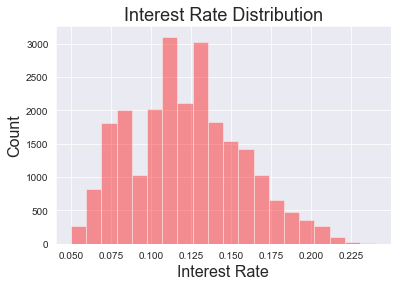

In [8]:
import seaborn as sns
sns.set_style('darkgrid')
d = lending_clean['int_rate']
sns.distplot(d, kde=False, color='red', bins = 20)
plt.rcParams['figure.dpi'] = 100
plt.title('Interest Rate Distribution', fontsize=18)
plt.xlabel('Interest Rate', fontsize=16)
plt.ylabel('Count', fontsize=16)

Our goal is to predict interest rates of new loans, we are going to do that by engineering a model that, based on a number of user features, sets interests rates.

Based on the Histogram of Interest rates above, we see that most loans have interests rates that fall between 0.075 and 0.170

Text(3.177256944444439, 0.5, 'Count')

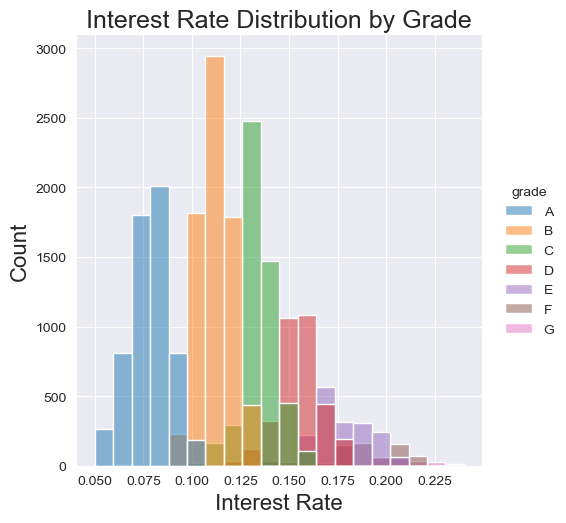

In [9]:
sns.set_style('darkgrid')
d = pd.to_numeric(lending_clean['int_rate'])
sns.displot(data = lending_clean, x = d, hue = 'grade', kde=False, bins = 20)
plt.rcParams['figure.dpi'] = 100
plt.title('Interest Rate Distribution by Grade', fontsize=18)
plt.xlabel('Interest Rate', fontsize=16)
plt.ylabel('Count', fontsize=16)

Based on the histogram above, its appraent that the grade the applicant falls in influences the interest they will pay, with grade A being the most favorable with low interest rates and grade G being the riskiest and attracting high interest rates.


In [10]:
%%capture
sns.set_style('darkgrid')
d = pd.to_numeric(lending_clean['int_rate'])
graph = sns.FacetGrid(lending_clean, col ='grade', hue = 'grade')
#decided not to use this code block

Now we investigate the ralationship between interest rates and the term of loan repayment

Text(5.943132716049378, 0.5, 'Count')

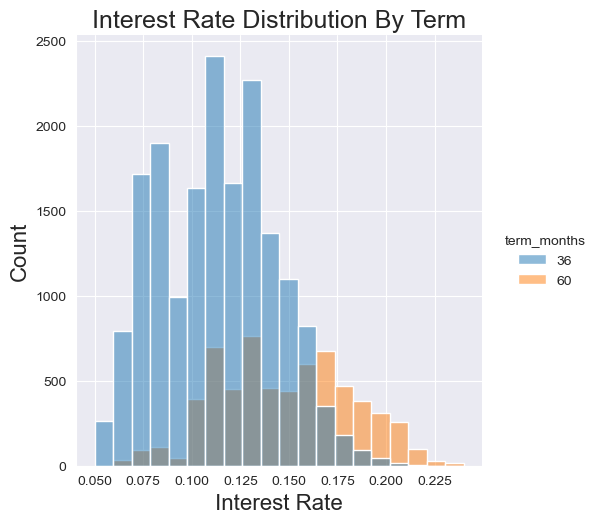

In [11]:
sns.set_style('darkgrid')
d = pd.to_numeric(lending_clean['int_rate'])
sns.displot(data = lending_clean, x = d, hue = 'term_months', kde=False, bins = 20)
plt.rcParams['figure.dpi'] = 100
plt.title('Interest Rate Distribution By Term', fontsize=18)
plt.xlabel('Interest Rate', fontsize=16)
plt.ylabel('Count', fontsize=16)

60 months repayment term loans tend to have a higher interest rates that short term loans. Long term loans are riskier, as expected. 

*What about loan amount?*

Text(0, 0.5, 'Interest Rate')

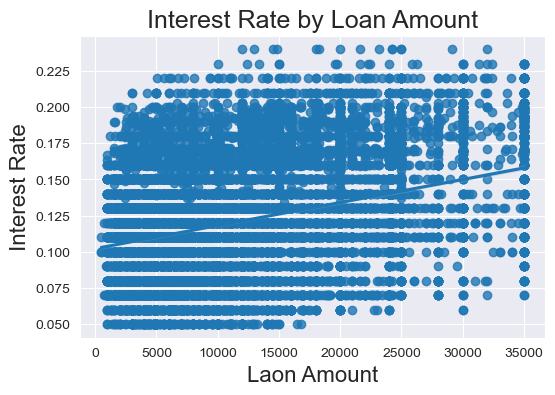

In [12]:
sns.set_style('darkgrid')
d = pd.to_numeric(lending_clean['int_rate'])
y1 = pd.to_numeric(lending_clean['loan_amnt'])
sns.regplot(data = lending_clean, x = y1, y = d)
plt.rcParams['figure.dpi'] = 100
plt.title('Interest Rate by Loan Amount', fontsize=18)
plt.xlabel('Laon Amount', fontsize=16)
plt.ylabel('Interest Rate', fontsize=16)

In the plot above , we can see that as loan amount increases, interest rate also increases as expected.

*What about deliquencies ? Do they affect interest rates?*

Text(0, 0.5, 'Interest Rate')

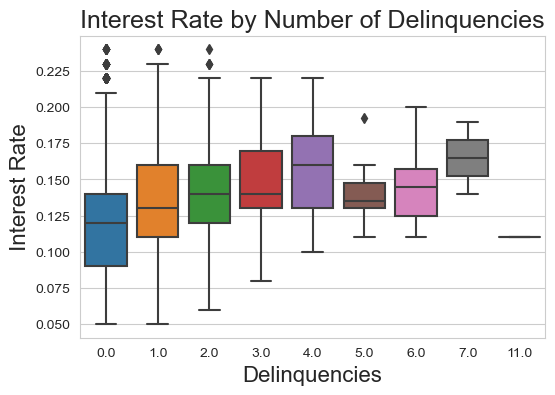

In [13]:
sns.set_style("whitegrid")
d = pd.to_numeric(lending_clean['int_rate'])
x1 = pd.to_numeric(lending_clean['delinq_2yrs'])
sns.boxplot(x = x1, y = d, data = lending_clean)
plt.title('Interest Rate by Number of Delinquencies', fontsize=18)
plt.xlabel('Delinquencies', fontsize=16)
plt.ylabel('Interest Rate', fontsize=16)

Number of delinquencies in the past 2 years have a effect on the interest rates to the loans given.

Now we an idea about how a few variables affect interest rates. I go on to visualise the numerical features on a scatterplot.

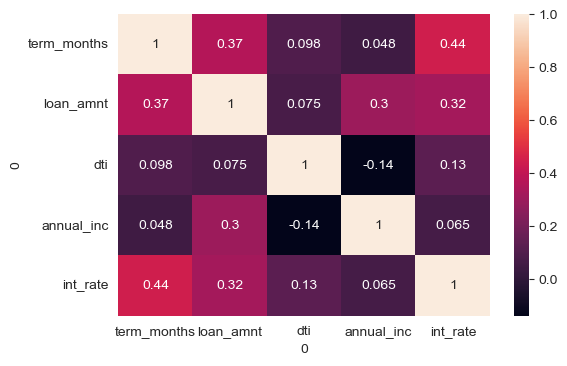

In [14]:
df = lending_clean.loc[:,['term_months', 'loan_amnt', 'dti', 'annual_inc', 'int_rate']]
df1 =df.apply(pd.to_numeric)
corrMatrix = df1.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### 3. Model Development

In [15]:
#Recoding the grade feature for modelling
lending_clean["grade"].replace({"A": "1",
                             "B": "2",
                             "C": "3",
                             "D": "4",
                             "E": "5",
                             "F": "6",
                             "G": "7"}, inplace=True)
cols = ['grade'] 
lending_clean[cols] = lending_clean[cols].astype('category')

In [16]:
# spliting predictor and target variables into X and y dataframes
y = lending_clean.int_rate
X = lending_clean.loc[:,['term_months', 'loan_amnt', 'dti', 'annual_inc', 'installment', 'grade']]
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

From the analysis above, I identified 6 features that are potential strong predictors for interest rates. Below I choose those features for modelling.

In [17]:
#selecting features
cols2 = ['term_months', 'loan_amnt', 'dti', 'annual_inc', 'installment', 'grade']

I also intorduce interaction terms: Perhaps the loan amount affects grade A loans differently than
grade B loans, and Non-linear terms: Perhaps a small increase in the loan amount doesn’t affect interest rate
so much but a large increase does. Below I take all six features and find 2nd and 3rd degree polynomial features. I also find interaction terms of each and every possible feature combination.

The resultant feature subspace dimension is 83. Which is a lot. Which is why I use Lasso regression to shrink least important features in our model. 

In [18]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction terms (interaction of each regressor pair + polynomial)
#Interaction terms need to be created in both the test and train datasets
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
interaction
#traning
X_inter = pd.DataFrame(interaction.fit_transform(X_train), columns=interaction.get_feature_names(input_features=cols2))
X_inter.head(3)

#test
X_inter_t = pd.DataFrame(interaction.fit_transform(X_test), columns=interaction.get_feature_names(input_features=cols2))
X_inter_t.head(3)


,term_months,loan_amnt,dti,annual_inc,installment,grade,term_months^2,term_months loan_amnt,term_months dti,term_months annual_inc,...,annual_inc^3,annual_inc^2 installment,annual_inc^2 grade,annual_inc installment^2,annual_inc installment grade,annual_inc grade^2,installment^3,installment^2 grade,installment grade^2,grade^3
0,60.0,14500.0,21.54,39000.0,352.77,4.0,3600.0,870000.0,1292.40,2340000.0,...,5.931900e+13,5.365632e+11,6.084000e+09,4.853420e+09,55032120.0,624000.0,4.390105e+07,4.977867e+05,5644.32,64.0
1,36.0,6000.0,6.56,46680.0,197.46,2.0,1296.0,216000.0,236.16,1680480.0,...,1.017168e+14,4.302698e+11,4.358045e+09,1.820074e+09,18434865.6,186720.0,7.699055e+06,7.798090e+04,789.84,8.0
2,36.0,25000.0,8.60,120000.0,818.35,2.0,1296.0,900000.0,309.60,4320000.0,...,1.728000e+15,1.178424e+13,2.880000e+10,8.036361e+10,196404000.0,480000.0,5.480463e+08,1.339393e+06,3273.40,8.0


#### Detecting Multicolinearity

Sometimes features can be highly correlated. This is very likely especially after creating features from polinomial terms and interactions. For example, annual income is likely to be negatively correlated with debt-to-income ratio. Similarly, loan amount will be positively correlated with loan amount square. In this case the two features convey similar information. This may generate some numerical problems in estimating the model (nearly singular rank matrix). Furthermore, if the model does estimate, the estimated coefficients may be unreliable. This is a problem for inferential statistics (when we actually care about the coefficients) but not such a big problem for prediction (as the prediction will continue to be accurate). Therefore I will just check for multicolinearity, but the information is not important in this case since we just want to predict.

In any case it is a good idea to check the data for multicolinearity problems. One way of doing this is by calculating the variance inflation factors (VIFs). For individual features the VIF is 1/R^2 of the linear regression of the feature against all other features. If the VIF is large (e.g., more than 10) we have a multicolinearity problem

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_inter.values, i) for i in range(X_inter.shape[1])]
vif["features"] = X_inter.columns
vif["VIF Factor"] = vif['VIF Factor'].round(decimals = 2).astype(int)
vif

,VIF Factor,features
0,12,term_months
1,1899392670,loan_amnt
2,34,dti
3,-2147483648,annual_inc
4,34433,installment
...,...,...
78,263,annual_inc grade^2
79,2830311,installment^3
80,145150,installment^2 grade
81,12499,installment grade^2


### Lasso Regression - Modelling with Regularisation

The main idea is to modify the OLS algorithm so that the estimated model becomes less sensitive to the training set. Remember that OLS minimizes the sum of square errors. LASSO minimizes the sum of square error plus λ times the sum of absolute values of the estimated coefficients.

The parameter λ≥0 (pronounced lambda) is called a hyper-parameter and it is user specified. If λ=0 the model reduces to the OLS algorithm. If λ>0 the model penalizes the objective for any coefficient that is different to zero. Therefore, for a coefficient to be different from zero by 1 unit it needs to reduce the sum of square errors by at least λ units.

By changing the least squares model the estimated coefficients and the predictions become biased. But the bias is something worth tolerating as the model’s predictions become less variable (lower error).

Since coefficients of different variables are measured in different units, it is important to standardize any continuous variable (subtract the mean and divide by standard deviation). Otherwise results will be misleading! Unlike linear regression, LASSO regression allows us to estimate a model even if we have more parameters to estimate than data points. Useful in a world of big data (e.g., detecting genes that are associated with specific phenotypes / disease).

In the example below are running a large model (lot’s of variables and interactions leading to 83 coefficients to be estimated).


In [20]:
l_min = 0.0
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

#numply arrays for saving rsquareds for different lambdas
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

In [21]:
from sklearn.model_selection import cross_val_score
#training a lasso model using a variety of lamdas
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_inter, y_train)
    results = cross_val_score(reg, X_inter, y_train, cv=10, scoring="r2") #10fold corss validation

    train_r_squared[ind] = reg.score(X_inter, y_train)  #recoding rsquared for training set  
    test_r_squared[ind] = reg.score(X_inter_t, y_test) #recording rsquared for testing set

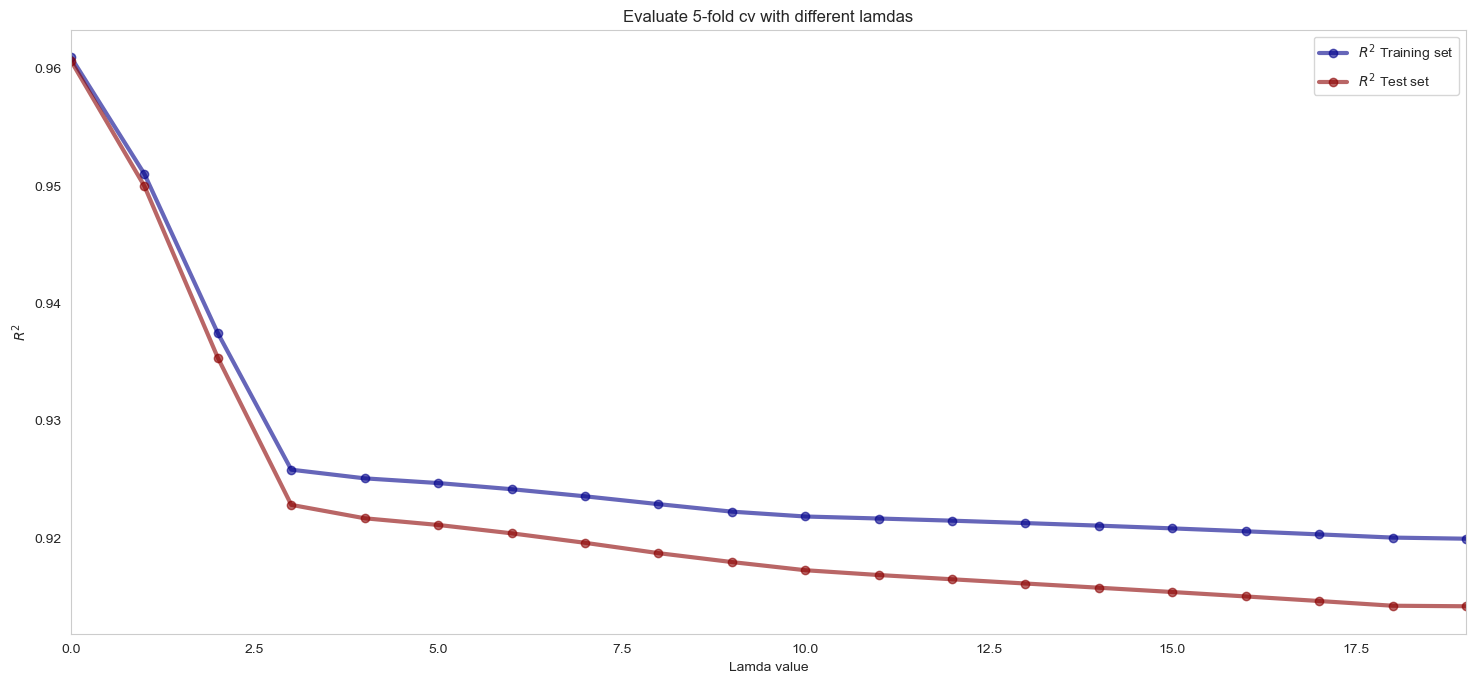

In [22]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

In [23]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    96.062855
lambda        0.000000
Name: 0, dtype: float64

#### Final Model

For the final model I take non-zero coeficient features from previous Lasso model and I use the features to train another lasso model and then test it on new examples on the testing dataset.

In [24]:
cols3 = pd.DataFrame(X_inter.columns.values.tolist())#get columns from the main training set
coefs = pd.DataFrame(reg.coef_) # get coeficients from previous lasso regression model
output_lasso = pd.concat([cols3, coefs], axis=1) #join the 2
output_ = pd.DataFrame(output_lasso)#convert to dataframe
output_.columns = ['features', 'coeficients'] #rename the columns
selected_features = output_.loc[output_['coeficients'] != 0] #select only features with non-zero coefficients for final model
columns_final = list(selected_features['features']) #save remaining features

In [25]:
#selecting final features for the final model
final_features_train = X_inter[columns_final]#training dataset for final model
final_features_test = X_inter_t[columns_final]#testing dataset for final Model

In [26]:
# Best Model, lambda chosen is 0.001
reg_best = Lasso(alpha = 0.001)
reg_best.fit(final_features_train, y_train) #training the chosen model on training set

Lasso(alpha=0.001)

In [27]:
#rsquared for the best model on testing set
reg_best.score(final_features_test, y_test)

0.9180882659861973

In [28]:
from sklearn.metrics import mean_squared_error
#RMSE for the the best model on testing set
mean_squared_error(y_test, reg_best.predict(final_features_test)).round(6)

0.000108

#### Results